In [18]:
print("Hello World")

Hello World


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne

In [3]:
raw = mne.io.read_raw_brainvision(
    "sub-00003_ses-1_task-sleep_run-20160712_2255.vhdr",
    preload=True
)
raw.set_channel_types({
    "ECG": "ecg",
    "EMG": "emg"
})


Extracting parameters from sub-00003_ses-1_task-sleep_run-20160712_2255.vhdr...
Setting channel info structure...


C:\Users\hp\AppData\Local\Temp\ipykernel_118860\59097562.py:1: RuntimeWarning: No coordinate information found for channels ['ECG', 'EMG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(


Reading 0 ... 748139  =      0.000 ...  2992.556 secs...


C:\Users\hp\AppData\Local\Temp\ipykernel_118860\59097562.py:1: RuntimeWarning: Not setting positions of 2 misc channels found in montage:
['ECG', 'EMG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(
C:\Users\hp\AppData\Local\Temp\ipykernel_118860\59097562.py:5: RuntimeWarning: The unit for channel(s) ECG, EMG has changed from NA to V.
  raw.set_channel_types({


<RawBrainVision | sub-00003_ses-1_task-sleep_run-20160712_2255.dat, 65 x 748140 (2992.6 s), ~371.1 MiB, data loaded>

In [5]:
print(raw.annotations)

<Annotations | 4992 segments: New Segment/ (1), Pulse Artifact/R (2570), ...>


### Visualize the data

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


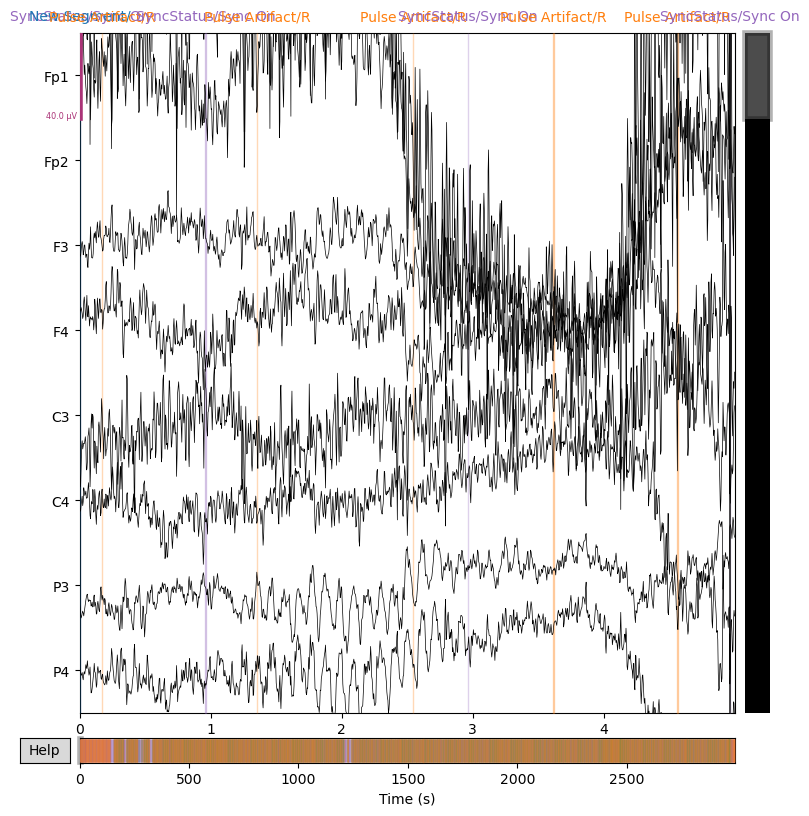

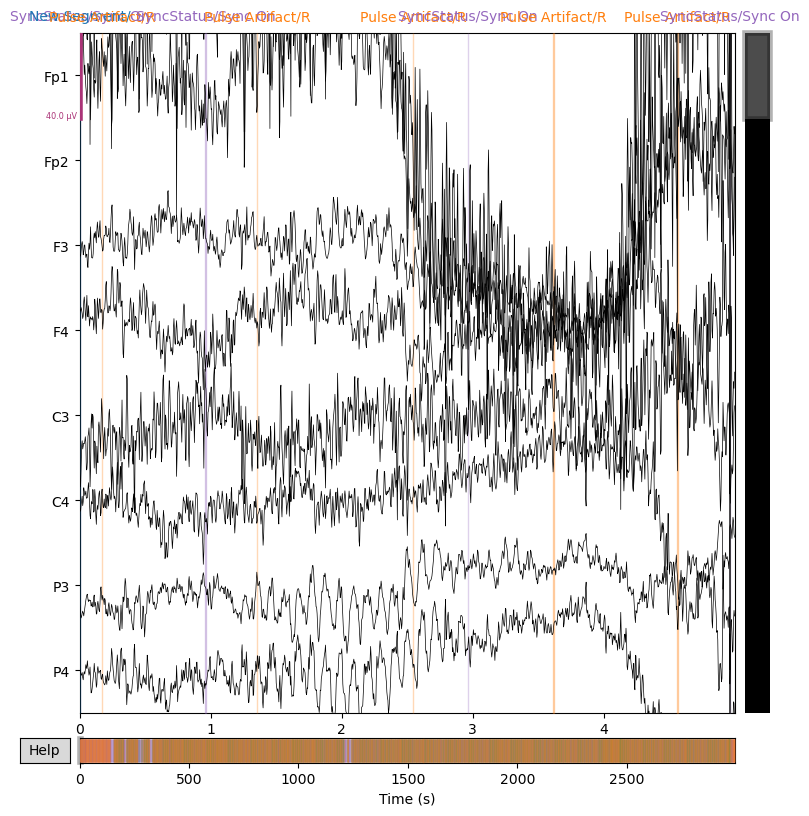

In [13]:
raw.pick_types(eeg=True)
raw.plot(n_channels=8, duration=5)

## Basic Preprocessing (Cleaning EEG)

#### Set EEG reference

In [11]:
# Average reference improves spatial interpretation
raw.set_eeg_reference('average', projection=False)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.


<RawBrainVision | sub-00003_ses-1_task-sleep_run-20160712_2255.dat, 63 x 748140 (2992.6 s), ~359.7 MiB, data loaded>

### Bandpass Filter

 #### EEG brain activity mostly lives between 1–40 Hz.

In [14]:
# Remove slow drift and high-frequency noise
raw.filter(l_freq=1.0, h_freq=40.0)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)



<RawBrainVision | sub-00003_ses-1_task-sleep_run-20160712_2255.dat, 63 x 748140 (2992.6 s), ~359.7 MiB, data loaded>

#### Remove Powerline Noise

In [15]:
raw.notch_filter(freqs=50) # removes electirical interference

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



<RawBrainVision | sub-00003_ses-1_task-sleep_run-20160712_2255.dat, 63 x 748140 (2992.6 s), ~359.7 MiB, data loaded>

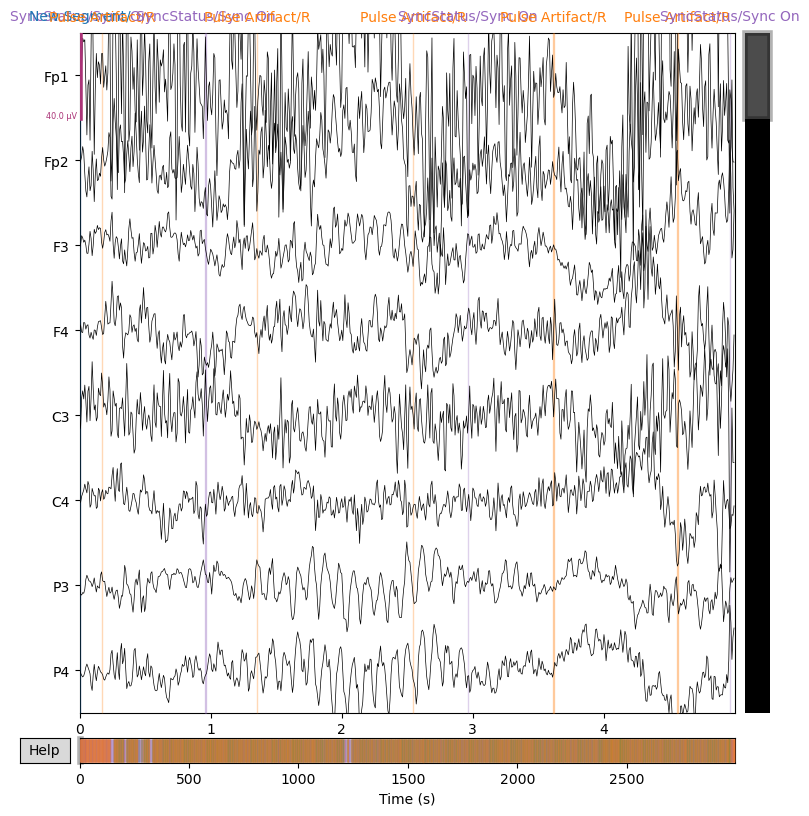

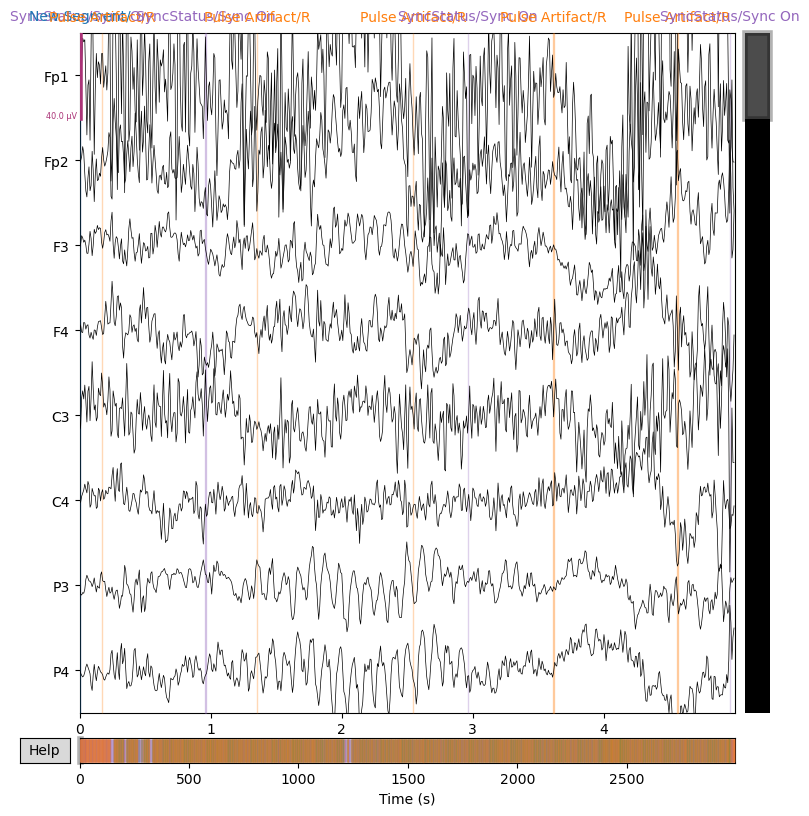

In [17]:
raw.plot(n_channels=8, duration=5)

### Remove Artifacts using ICA

In [18]:
from mne.preprocessing import ICA

In [19]:
# Create ICA model
ica = ICA(n_components=20, random_state=97)

# Fit ICA to data
ica.fit(raw)

Fitting ICA to data using 63 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 36.4s.


<ICA | raw data decomposition, method: fastica (fit in 26 iterations on 748140 samples), 20 ICA components (63 PCA components available), channel types: eeg, no sources marked for exclusion>

In [24]:
ica.exclude = [0, 2]

# Apply cleaning
raw_clean = ica.apply(raw.copy())

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 63 PCA components


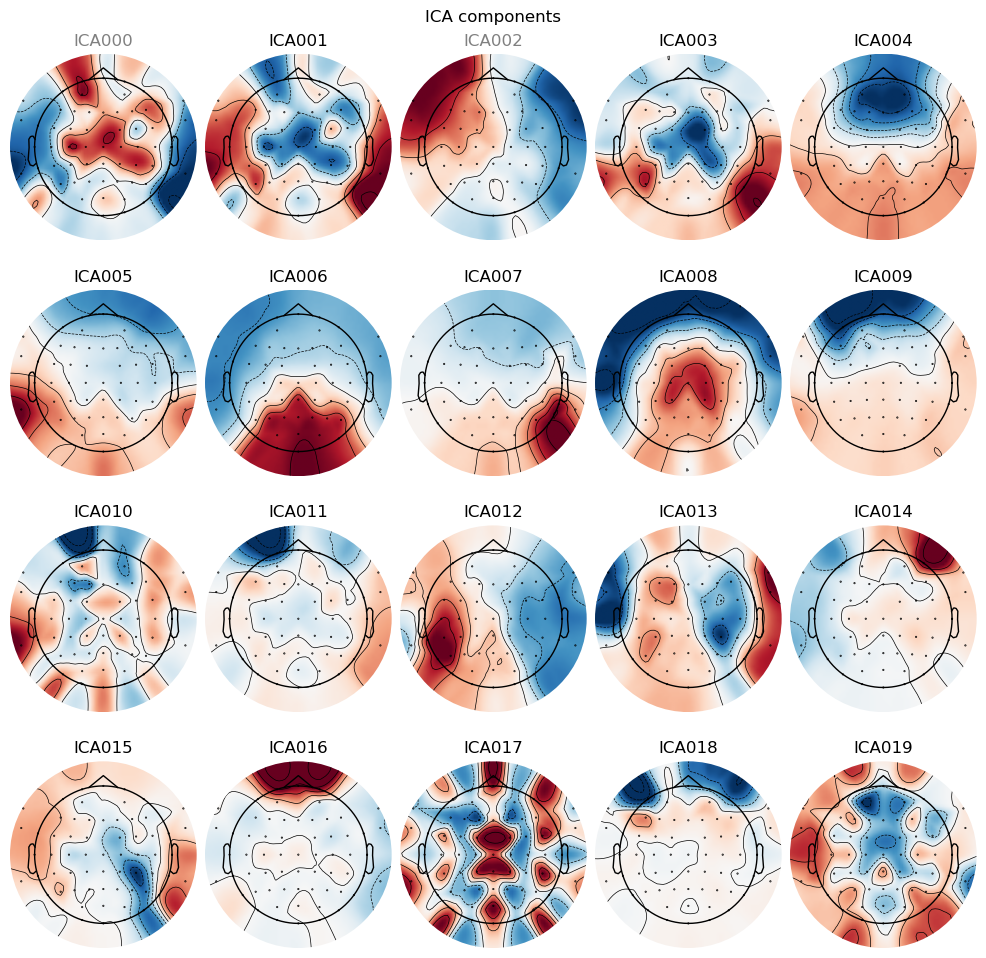

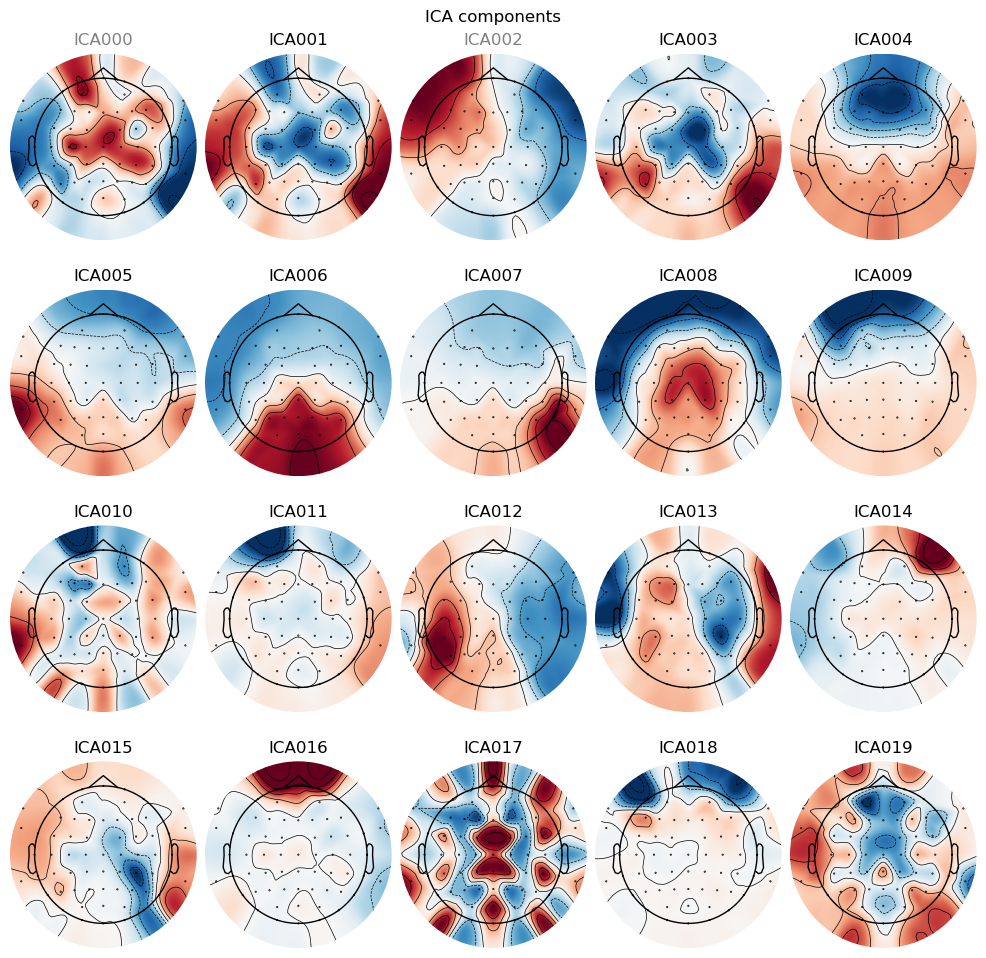

In [25]:
# Visualize components
ica.plot_components()

## Creating time window for brain states

### We divide signal into segments (epochs).

In [26]:
# Create fixed-length windows (2 seconds each)
epochs = mne.make_fixed_length_epochs(
    raw_clean,
    duration=2.0,
    overlap=1.0
)

Not setting metadata
2991 matching events found
No baseline correction applied
0 projection items activated


## Functional Connectivity Networks

### Compute connectivity

In [34]:
from mne_connectivity import spectral_connectivity_epochs

In [ ]:
conn = spectral_connectivity_epochs(
    epochs,
    method='coh',      # coherence connectivity
    sfreq=raw.info['sfreq'],
    fmin=8,            # alpha band
    fmax=12,
    verbose=True
)

In [36]:
conn_matrix = conn.get_data(output='dense')[:, :, 0]
print(conn_matrix.shape)

(63, 63)


## Brain state switching

### Extract power features

In [58]:
psds = epochs.compute_psd(
    method="welch",   # Welch method
    fmin=1,           # minimum frequency
    fmax=40           # maximum frequency
)

# Extract numerical data
psds_data = psds.get_data()
freqs = psds.freqs

Using data from preloaded Raw for 2991 events and 500 original time points ...
Effective window size : 2.000 (s)


In [59]:
print(psds_data.shape)

(2991, 63, 79)


### Features for Brain-State Clustering

In [60]:
bands = {
    "delta": (1,4),
    "theta": (4,8),
    "alpha": (8,12),
    "beta": (13,30)
}

band_features = []

for fmin, fmax in bands.values():
    band_psd = epochs.compute_psd(
        method="welch",
        fmin=fmin,
        fmax=fmax
    ).get_data().mean(axis=2)

    band_features.append(band_psd)

# Combine all bands
features = np.concatenate(band_features, axis=1)

print(features.shape)

Using data from preloaded Raw for 2991 events and 500 original time points ...
Effective window size : 2.000 (s)
Using data from preloaded Raw for 2991 events and 500 original time points ...
Effective window size : 2.000 (s)
Using data from preloaded Raw for 2991 events and 500 original time points ...
Effective window size : 2.000 (s)
Using data from preloaded Raw for 2991 events and 500 original time points ...
Effective window size : 2.000 (s)
(2991, 252)


### convert to matrix

In [61]:
conn_matrix = conn.get_data(output='dense')[:, :, 0]
print(conn_matrix.shape)

(63, 63)


In [62]:
import os

# Suppose your CPU has 8 cores
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

In [63]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=0)
states = kmeans.fit_predict(features)

In [64]:
print(states)

[0 0 0 ... 0 0 0]


### Visualize switching

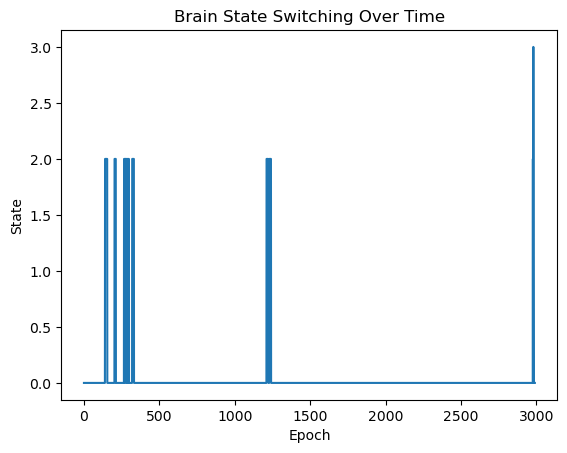

In [65]:
plt.plot(states)
plt.title("Brain State Switching Over Time")
plt.xlabel("Epoch")
plt.ylabel("State")
plt.show()

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\Users\hp\anaconda3\Lib\site-packages\mne\viz\utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


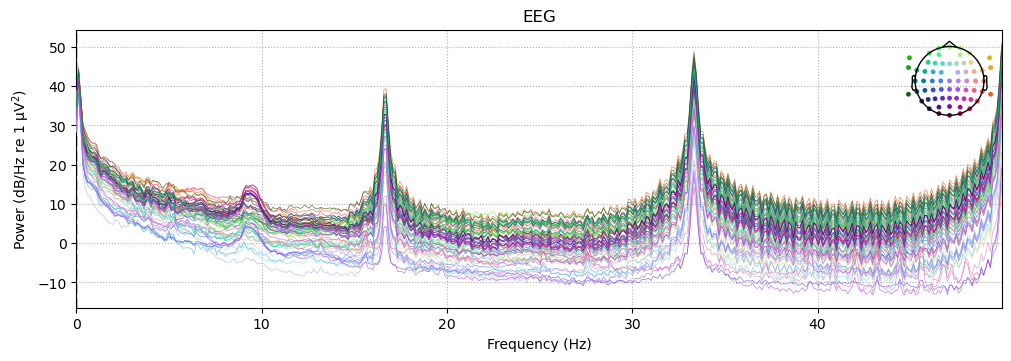

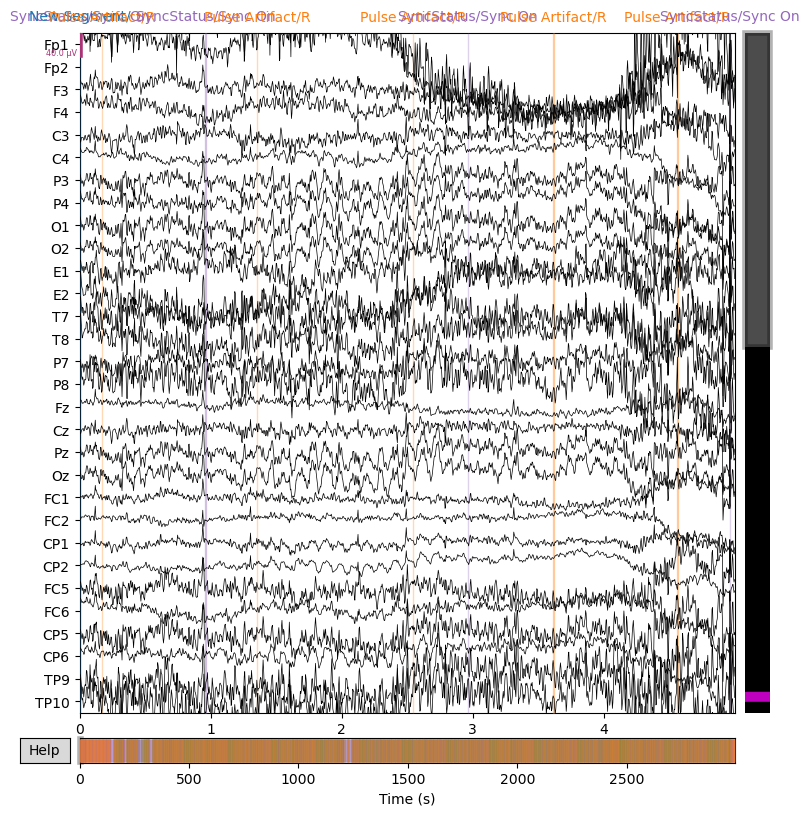

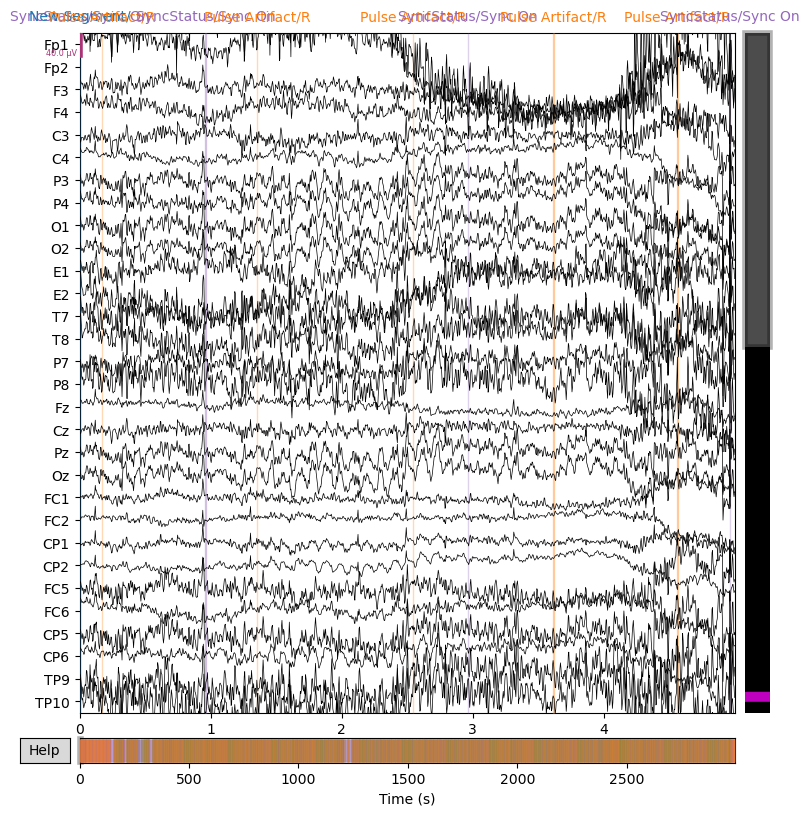

In [29]:
raw.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)
raw.plot(duration=5, n_channels=30)

In [14]:
#mne.io.read_raw_fif(raw)
mne.io.read_raw_eyelink(raw)

TypeError: fname must be an instance of path-like, got <class 'mne.io.brainvision.brainvision.RawBrainVision'> instead.

In [10]:
df = pd.read_csv("participants.tsv", sep="\t")

In [14]:

df.describe

<bound method NDFrame.describe of    participant_id   age sex handedness
0       sub-00002  22.0   M      right
1       sub-00003  33.1   F      right
2       sub-00006  25.4   M      right
3       sub-00014  24.0   M      right
4       sub-00029  30.3   F      right
5       sub-00040  29.2   M      right
6       sub-00047  23.9   F      right
7       sub-00053  31.7   F      right
8       sub-00056  24.0   F      right
9       sub-00060  20.8   M      right
10      sub-00063  23.7   M      right
11      sub-00065  23.8   F      right
12      sub-00067  22.2   M      right
13      sub-00078  21.6   F      right
14      sub-00086  24.1   F      right
15      sub-00105  23.9   F      right>